In [1]:
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
env = gym.make("Taxi-v3")
env.reset()
env.render()

In [47]:
num_rows= env.observation_space.n
num_columns= env.action_space.n 

qtable_MC = np.zeros((5, 5, 5, 4, env.action_space.n))
qtable_TD = np.zeros((5, 5, 5, 4, env.action_space.n))

returns = np.zeros((5, 5, 5, 4, env.action_space.n))
N = np.zeros((5, 5, 5, 4, env.action_space.n))

In [3]:
episode_MC=5000
alpha_MC=0.7
gamma_MC=0.95
epsilon_MC=0.4
cumulative_rewards_MC = np.zeros(episode_MC)

In [4]:
outcomes_MC = []

for i in range(episode_MC):
    state=env.reset()
    done= False
    state=state[0]
    curr_outcome="Failure"
    episode_data = []
    outcomes_MC.append(curr_outcome)
    
    while not done:
        destination=int(state%4)
        state=(state-destination)/4
        passenger_location = int(state % 5)
        state=(state-passenger_location)/5    
        taxi_col =int(state % 5)
        taxi_row=int((state-taxi_col)/5)    
        
        if np.random.uniform(0,1) < epsilon_MC:
            action= env.action_space.sample()
        elif np.max(qtable_MC[taxi_row, taxi_col, passenger_location, destination]) > 0 :
            action = np.argmax(qtable_MC[taxi_row, taxi_col, passenger_location, destination])
        else:
            action = env.action_space.sample()
            
        next_state,reward,terminated,truncated,info=env.step(action)    
        done = truncated or terminated
        episode_data.append((next_state, action, reward))
        state = next_state
        cumulative_rewards_MC[i] += reward
        if reward==20:
            outcomes_MC[-1]= "Success"
    G = 0
    for t in range(len(episode_data)-1, -1, -1):
        state, action, reward = episode_data[t]
        destination=int(state%4)
        state=(state-destination)/4
        passenger_location = int(state % 5)
        state=(state-passenger_location)/5    
        taxi_col =int(state % 5)
        taxi_row=int((state-taxi_col)/5)    

        G = gamma_MC * G + reward
        N[taxi_row, taxi_col, passenger_location, destination,action] += 1
        returns[taxi_row, taxi_col, passenger_location, destination,action]+= alpha_MC*(G - returns[taxi_row, taxi_col, passenger_location, destination,action])
        qtable_MC[taxi_row, taxi_col, passenger_location, destination,action] = returns[taxi_row, taxi_col, passenger_location, destination,action]

NameError: name 'qtable_MC' is not defined

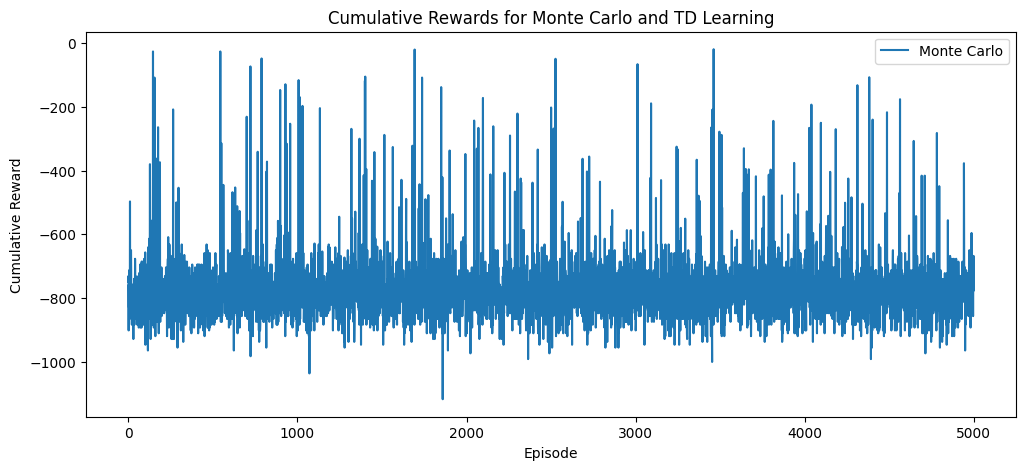

In [50]:
plt.figure(figsize=(12,5))
plt.plot(range(5000), cumulative_rewards_MC, label='Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards for Monte Carlo and TD Learning')
plt.legend()
plt.show()

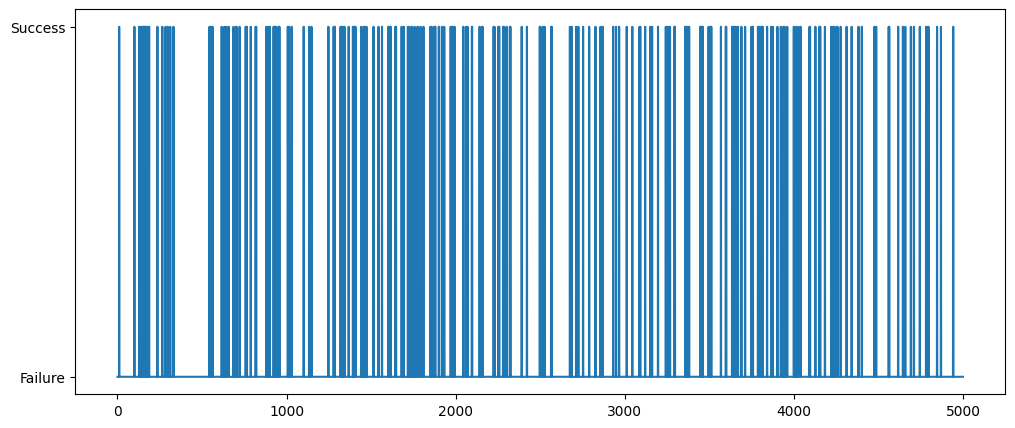

In [51]:
plt.figure(figsize=(12,5))
plt.plot(range(5000),outcomes_MC)

In [52]:
print(qtable_MC)

[[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  2.00000000e+01]
    [ 0.00000000e+00 -5.81674072e+01  0.00000000e+00 -5.86144951e+01
      0.00000000e+00 -6.06908975e+01]
    [ 0.00000000e+00 -6.33824524e+01  0.00000000e+00 -7.02774737e+01
      0.00000000e+00 -6.92248828e+01]
    [ 0.00000000e+00 -4.80934125e+01  0.00000000e+00 -4.54149078e+01
      0.00000000e+00 -4.94322544e+01]]

   [[ 0.00000000e+00 -7.41203834e+01  0.00000000e+00 -6.67189242e+01
     -7.32423482e+01 -7.59190711e+01]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00 -1.01341675e+02  0.00000000e+00 -6.89124456e+01
     -8.53143238e+01 -1.05368521e+02]
    [ 0.00000000e+00 -6.20162265e+01  0.00000000e+00 -9.21566541e+01
     -7.05448690e+01 -7.78430158e+01]]

   [[ 0.00000000e+00 -6.34465469e+01  0.00000000e+00 -4.15354676e+01
     -8.49847576e+01 -7.31461844e+01]
    [ 0.00000000e+00 -7.94473129e

In [53]:
episode_TD=5000
alpha_TD=0.5
gamma_TD=0.9
epsilon_TD=0.1

cumulative_rewards_TD = np.zeros(episode_TD)

In [59]:
outcomes_TD = []
def decoder(state):
        destination=int(state%4)
        state=(state-destination)/4
        passenger_location = int(state % 5)
        state=(state-passenger_location)/5    
        taxi_col =int(state % 5)
        taxi_row=int((state-taxi_col)/5)    
        return taxi_row, taxi_col, passenger_location, destination
    
for i in range(episode_MC):
    state=env.reset()
    done= False
    state=state[0]
    curr_outcome="Failure"
    outcomes_TD.append(curr_outcome)
    
    while not done:
        taxi_row, taxi_col, passenger_location, destination = decoder(state)

        if np.random.uniform(0,1) < epsilon_TD:
            action= env.action_space.sample()
        elif np.max(qtable_TD[taxi_row, taxi_col, passenger_location, destination]) > 0 :
            action = np.argmax(qtable_TD[taxi_row, taxi_col, passenger_location, destination])
        else:
            action = env.action_space.sample()
        
        new_state,reward,terminated,truncated,info=env.step(action)    
        new_taxi_row, new_taxi_col, new_passenger_location, new_destination = decoder(new_state)

        done = truncated or terminated
        qtable_TD[taxi_row, taxi_col, passenger_location, destination,action] += alpha_TD * (reward + gamma_TD * np.max(qtable_TD[new_taxi_row, new_taxi_col, new_passenger_location, new_destination]) - qtable_TD[taxi_row, taxi_col, passenger_location, destination,action])
        state = new_state
        cumulative_rewards_TD[i] += reward
        
        if reward==20:
            outcomes_TD[-1]= "Success"



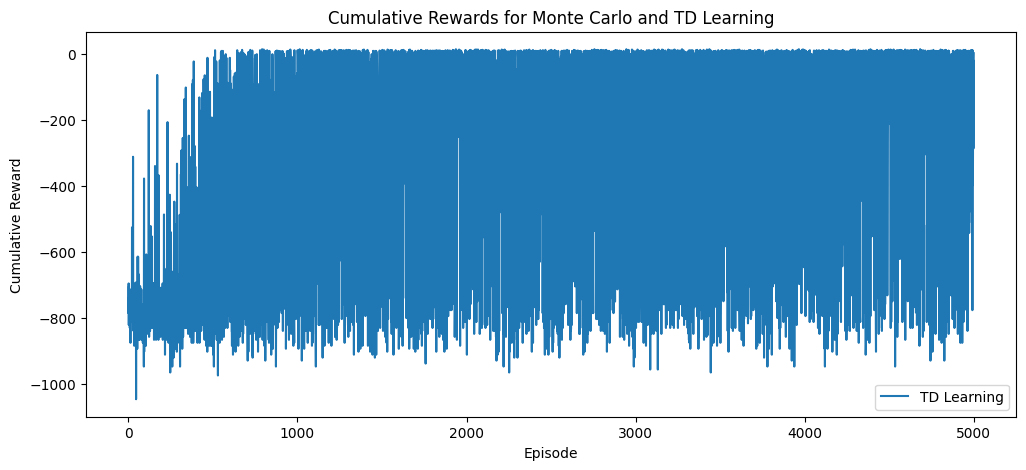

In [60]:
plt.figure(figsize=(12,5))
plt.plot(range(5000), cumulative_rewards_TD, label='TD Learning')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards for Monte Carlo and TD Learning')
plt.legend()
plt.show()

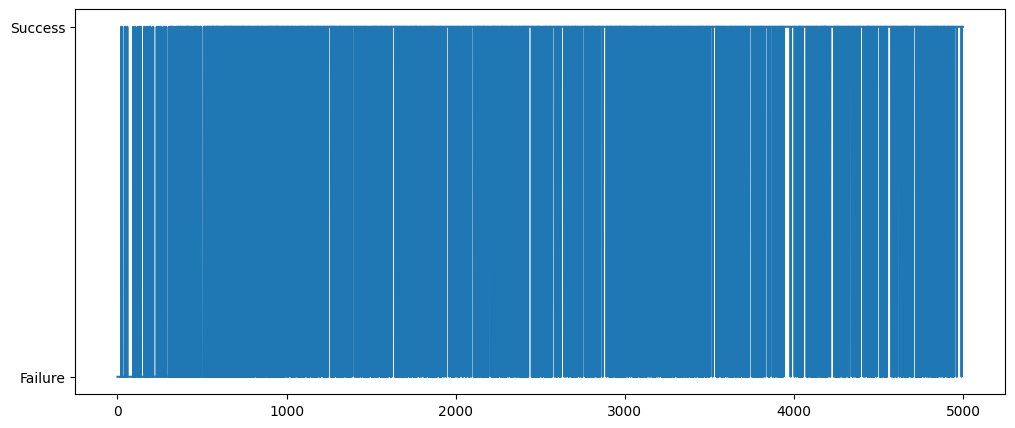

In [61]:
plt.figure(figsize=(12,5))
plt.plot(range(5000),outcomes_TD)

In [62]:
print(qtable_TD)

[[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [-6.22852229e-01  4.68008069e-03 -6.52748428e-01  3.97458034e-01
      1.62261467e+00 -8.73410194e+00]
    [ 4.29423663e+00  5.69014213e+00  3.99824841e+00  5.83425154e+00
      7.71470000e+00 -3.17821825e+00]
    [-6.08394619e-01  4.82548402e-01 -9.76474549e-01  1.02937381e+00
      2.91401630e+00 -7.73980813e+00]]

   [[-4.99684549e+00 -5.49716094e+00 -4.99684549e+00 -5.49716094e+00
     -1.44971609e+01 -1.44971609e+01]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00]
    [-4.99684549e+00 -5.49716094e+00 -4.99684549e+00 -5.49716094e+00
     -1.44971609e+01 -1.44971609e+01]
    [-3.13696226e+00 -3.82326604e+00 -3.13696226e+00 -3.82326604e+00
     -1.28232660e+01 -1.28232660e+01]]

   [[ 1.62261459e+00 -1.25119251e+00 -3.89117674e+00 -1.44247780e+00
     -1.07822802e+01 -1.08772324e+01]
    [-2.37440252e+00 -3.13696226e